Two methods:
* Append predictions to modeling dataset, train and predict
* Use predictions as modeling dataset, train and predict

In [43]:
import pandas as pd
import numpy as np
import random

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, cross_validate
from xgboost.sklearn import XGBClassifier

import xgboost as xgb
import matplotlib.pyplot as plt
import os

### Append predictions to full data:

In [23]:
# Import predictions
lgbm_preds_train = pd.read_csv("../04-modeling/stacking_predictions/train_fe_data_Final_LGBM_no_rounding.csv")
lgbm_preds_test = pd.read_csv("../04-modeling/stacking_predictions/test_fe_data_Final_LGBM_no_rounding.csv")
xgb_preds_train = pd.read_csv("../04-modeling/stacking_predictions/train_fe_data_Final_xgboost_with_CV_no_rounding.csv")
xgb_preds_test = pd.read_csv("../04-modeling/stacking_predictions/test_fe_data_Final_xgboost_with_CV_no_rounding.csv")
rf_preds_train = pd.read_csv("../04-modeling/stacking_predictions/train_fe_data_Final_RF_no_rounding.csv")
rf_preds_test = pd.read_csv("../04-modeling/stacking_predictions/test_fe_data_Final_RF_no_rounding.csv")

# Import train and test
train = pd.read_csv("../03-data-creation/train_FE_final.csv")
test = pd.read_csv("../03-data-creation/test_FE_final.csv")

# Drop unwanted column
train = train.drop("Unnamed: 0", axis = 1)
test = test.drop("Unnamed: 0", axis = 1)

# Add predictions rows
train['Predicted_LGBM'] = lgbm_preds_train['Predicted_LGBM']
test['Predicted_LGBM'] = lgbm_preds_test['Predicted_LGBM']
train['Predicted_XGB'] = xgb_preds_train['Predicted_XGB']
test['Predicted_XGB'] = xgb_preds_test['Predicted_XGB']
train['Predicted_RF'] = rf_preds_train['Predicted_RF']
test['Predicted_RF'] = rf_preds_test['Predicted_RF']

# We don't want the ID to be used in the model so preserve
train_id = train['id']
test_id = test['id']

train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)

# Split X and y
X = train.loc[:, train.columns != "satisfied"]
y = train.satisfied

In [76]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 3096)

# Single XGB, no CV, default params
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

roc=metrics.roc_auc_score(y_test, y_pred)

print(roc)
print(metrics.confusion_matrix(y_test, y_pred))

0.8070249628950831
[[3226 1065]
 [ 652 4081]]


In [63]:
# Guide to HyperOpt: https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model
# Some constants
SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'satisfied'

# Utility functions

def intersect(l_1, l_2):
    return list(set(l_1) & set(l_2))

def get_features(train, test):
    intersecting_features = intersect(train.columns, test.columns)
    return sorted(intersecting_features)

# Scoring and optimization functions


def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(train_features, label=y_train)
    dvalid = xgb.DMatrix(valid_features, label=y_valid)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_valid, predictions)
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize(
             #trials, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=50)
    return best

In [61]:
FEATURES = get_features(train, test)

# Extract the train and valid (used for validation) dataframes from the train_df

train, valid = train_test_split(train, test_size=VALID_SIZE,
                                random_state=SEED)
train_features = train[FEATURES]
valid_features = valid[FEATURES]
y_train = train[TARGET]
y_valid = valid[TARGET]

print('The training set is of length: ', len(train.index))
print('The validation set is of length: ', len(valid.index))

The training set is of length:  15400
The validation set is of length:  3850


In [ ]:
best_hyperparams = optimize(
                            #trials
                            )
print("The best hyperparameters are: ", "\n")

In [81]:
print(best_hyperparams)

{'colsample_bytree': 0.8, 'eta': 0.05, 'gamma': 0.6000000000000001, 'max_depth': 1, 'min_child_weight': 3.0, 'n_estimators': 184.0, 'subsample': 0.65}


In [83]:
# Fit model & predict

tuned_model = xgb.XGBClassifier(objective="binary:logistic",
                               colsample_bytree = 0.8,
                               eta = 0.05,
                               gamma = 0.6,
                               max_depth = 1,
                               min_child_weight = 3,
                               n_estimators = 184,
                               subsample = 0.65)
tuned_model.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.05, gamma=0.6,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.0500000007, max_delta_step=0, max_depth=1,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=184, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.65,
              tree_method=None, validate_parameters=False, verbosity=None)

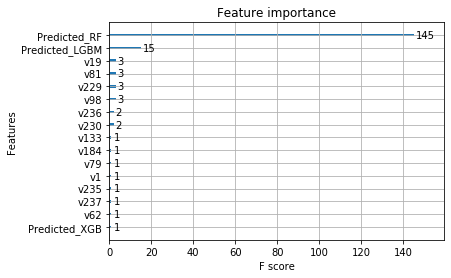

In [99]:
xgb.plot_importance(tuned_model)

In [96]:
test_new = test.copy()
test_preds = pd.DataFrame(tuned_model.predict(test))
test_new['id'] = test_id
test_new['Predicted'] = test_preds

test_new[['id', 'Predicted']].to_csv('/Users/sabrinatan/Desktop/STAT 441/stat441-W20-project/04-modeling/stacking_predictions/stacked_XGB_1_FullData.csv', index = False, float_format = "%.8f")



### Using only the predictions:

In [ ]:
# New DFs
model_reduced = ['Predicted_LGBM', 'Predicted_XGB', 'Predicted_RF', 'satisfied']
train_reduced = train[model_reduced]
train_reduced = test[model_reduced]

# Split X and y
X_reduced = train_reduced.loc[:, train_reduced.columns != "satisfied"]
y_reduced = train_reduced.satisfied

In [ ]:
# Split data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y_reduced, test_size=0.30, random_state = 3096)

# Single XGB, no CV, default params
xgb_model_r = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_mode_rl.fit(X_train_r, y_train_r)

y_pred_r = xgb_model.predict(X_test_r)

roc_r = metrics.roc_auc_score(y_test_r, y_pred_r)

print(roc_r)
print(metrics.confusion_matrix(y_test_r, y_pred_r))

In [ ]:
FEATURES = get_features(train_reduced, test_reduced)

# Extract the train and valid (used for validation) dataframes from the train_df

train_r, valid_r = train_test_split(train_reduced, test_size=VALID_SIZE,
                                random_state=SEED)
train_features_r = train_r[FEATURES]
valid_features_r = valid_r[FEATURES]
y_train_r = train_r[TARGET]
y_valid_r = valid_r[TARGET]

print('The training set is of length: ', len(train_r.index))
print('The validation set is of length: ', len(valid_r.index))

In [ ]:
best_hyperparams_r = optimize(
                            #trials
                            )
print("The best hyperparameters are: ", "\n")
print(best_hyperparams_r)